Here we train one catboost model. There are two control flows. One involves training on all but last two months data and validating on the last two months data. Second is training on all of data and using the model to predict on test.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import gc
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from catboost import CatBoostRegressor
from catboost import Pool
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


In [2]:
# If false, then we run a split data to train,validation and then see the performance. If true then we train using all data and predict for test.
FINAL_MODEL_FOR_TEST = False
if FINAL_MODEL_FOR_TEST:
    print('Using all data to train the model and predict on test data using it')
else:
    print('Dividing data to train and validation and evaluating performance on validation.')

Dividing data to train and validation and evaluating performance on validation.


In [3]:
TRAINED_MODEL_FPATH = 'all_data_model.bin'
SAMPLE_SUBMISSION_FPATH = '../input/competitive-data-science-predict-future-sales/sample_submission.csv'
ORIG_SALES_FPATH = '../input/competitive-data-science-predict-future-sales/sales_train.csv'
ORIG_ITEMS_FPATH = '../input/competitive-data-science-predict-future-sales/items.csv'

COMBINED_DATA_FPATH = '../input/textdatanumericdatacombined/DATA_WITH_TXT.h5'

X_0=pd.read_hdf(COMBINED_DATA_FPATH,'X_0')
X_1=pd.read_hdf(COMBINED_DATA_FPATH,'X_1')
X_2=pd.read_hdf(COMBINED_DATA_FPATH,'X_2')
y=pd.read_hdf(COMBINED_DATA_FPATH,'y')

X = pd.concat([X_0,X_1,X_2])
del X_0,X_1,X_2
gc.collect()

69

In [4]:
text_cols = [c for c in X.columns if 'item_category_name' in c or 'shop_name_text' in c ]

In [5]:
X[text_cols] = X[text_cols].astype(np.float16)

In [6]:
columns_to_remove =[
    'item_cnt_day_1M_min',
 'item_cnt_day_1M_max',
 'item_cnt_day_1M_0.25_q',
 'item_cnt_day_1M_0.5_q',
 'item_cnt_day_1M_0.75_q',
 'item_cnt_day_1M_0.9_q',
 'item_cnt_day_2M_0.25_q',
 'item_cnt_day_2M_0.5_q',
 'item_cnt_day_2M_0.75_q',
 'item_cnt_day_2M_0.9_q',
 'item_cnt_day_4M_0.25_q',
 'item_cnt_day_4M_0.9_q',
#  'orig_item_id',
 'last_item_price',
 'avg_category_item_price',
#  neighbour features  
'1Neighbor_std_dollar_value',
'2Neighbor_std_dollar_value',
'1Neighbor_item_cnt_day_2M_sum',
'2Neighbor_item_cnt_day_2M_sum',
'1Neighbor_item_cnt_day_1M_sum',
'2Neighbor_item_cnt_day_1M_sum',
]

In [7]:
X.drop(columns_to_remove, axis=1,inplace=True)

In [8]:
neighbor_cols = [c for c in X.columns.tolist() if 'Neighbor' in c]
neighbor_cols

['6Neighbor_std_dollar_value',
 '6Neighbor_item_cnt_day_2M_sum',
 '6Neighbor_item_cnt_day_1M_sum']

In [9]:
gc.collect()

14

In [10]:
# X.loc[X.orig_item_id_oldness >1, neighbor_cols] = -100

In [11]:
y = y.loc[X.index]


In [12]:
assert y.index.equals(X.index)

In [13]:
if not FINAL_MODEL_FOR_TEST:
    train_X = X[X.date_block_num <32]
    train_y = y.loc[train_X.index]
    val_X = X[X.date_block_num >=32]
    val_y = y.loc[val_X.index]


In [14]:
if not FINAL_MODEL_FOR_TEST:
    del X, y
    train_X.drop(['item_id','orig_item_id','date_block_num'], axis=1,inplace=True)
    val_X.drop(['item_id','orig_item_id','date_block_num'], axis=1,inplace=True)
    val_X = val_X[train_X.columns]
else:
    X.drop(['item_id','orig_item_id','date_block_num'], axis=1,inplace=True)

In [15]:
gc.collect()

7

In [16]:
regressor_kwargs = {
    'depth': 14,
    'iterations':5000,
    'random_seed':0,
    'learning_rate':0.03,
    'od_type':'Iter',
    'od_wait':300,
    'task_type':'GPU',
#     'l2_leaf_reg':10,
        }

In [17]:
if not FINAL_MODEL_FOR_TEST:
    X_cols = train_X.columns.tolist()
    pool_train = Pool(data=train_X,label=train_y)
    pool_val = Pool(data=val_X,label=val_y)    
else:    
    X_cols = X.columns.tolist()
    pool_train = Pool(data=X,label=y)
    num_models = 2469
    regressor_kwargs['iterations'] = num_models

print(X_cols)

['item_cnt_day_1M_sum', 'item_cnt_day_2M_sum', 'item_cnt_day_2M_min', 'item_cnt_day_2M_max', 'item_cnt_day_4M_sum', 'item_cnt_day_4M_min', 'item_cnt_day_4M_max', 'item_cnt_day_4M_0.5_q', 'item_cnt_day_4M_0.75_q', 'month', 'year', 'shop_id', 'item_category_id', 'avg_item_price', 'std_item_price', 'category_item_price', 'sub_category_item_price', 'avg_sub_category_item_price', 'avg_dollar_value', 'last_dollar_value', 'std_dollar_value', 'category_dollar_value', 'sub_category_dollar_value', 'avg_category_dollar_value', 'avg_sub_category_dollar_value', 'orig_item_id_oldness', 'orig_item_id_is_fm', 'orig_item_id_shop_id_oldness', 'orig_item_id_shop_id_is_fm', 'item_cnt_day_1M_sum_3M', 'item_cnt_day_1M_sum_6M', 'item_cnt_day_1M_sum_12M', 'city_id', 'city_lat', 'city_lon', 'city_importance', 'city_area', 'item_id_enc', 'item_category_id_enc', 'shop_id_enc', 'item_shop_id_enc', 'shop_category_id_enc', 'item_id_qt_0.1_enc', 'item_category_id_qt_0.1_enc', 'shop_id_qt_0.1_enc', 'shop_category_id_

In [18]:
model = CatBoostRegressor(**regressor_kwargs)
if not FINAL_MODEL_FOR_TEST:
    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=100,
        plot=True
    )
else:
     model.fit(
        pool_train,    
        verbose=100,
        plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.4587600	test: 1.1654847	best: 1.1654847 (0)	total: 234ms	remaining: 19m 31s
100:	learn: 0.9514854	test: 0.8608004	best: 0.8608004 (100)	total: 23s	remaining: 18m 36s
200:	learn: 0.8963093	test: 0.8514214	best: 0.8514112 (199)	total: 46.2s	remaining: 18m 23s
300:	learn: 0.8614694	test: 0.8463085	best: 0.8463085 (300)	total: 1m 9s	remaining: 18m 10s
400:	learn: 0.8363989	test: 0.8432757	best: 0.8432577 (397)	total: 1m 33s	remaining: 17m 51s
500:	learn: 0.8157257	test: 0.8415131	best: 0.8415131 (500)	total: 1m 56s	remaining: 17m 28s
600:	learn: 0.8000501	test: 0.8392728	best: 0.8392577 (599)	total: 2m 20s	remaining: 17m 7s
700:	learn: 0.7858827	test: 0.8374404	best: 0.8374404 (700)	total: 2m 43s	remaining: 16m 45s
800:	learn: 0.7741249	test: 0.8360693	best: 0.8360663 (799)	total: 3m 7s	remaining: 16m 23s
900:	learn: 0.7625244	test: 0.8350675	best: 0.8349715 (894)	total: 3m 31s	remaining: 16m 1s
1000:	learn: 0.7523355	test: 0.8346866	best: 0.8345876 (983)	total: 3m 54s	remainin

Net Square error
 orig_item_id_oldness
0     92515.339708
1     36438.437423
2     16983.768952
3     10641.471268
4      7673.838526
5     20832.805563
6     13982.624579
7      5919.334914
8      4822.677363
9      6153.089855
10     8547.946553
11     7204.478106
12    10475.075994
13     5347.729216
14     2452.696363
15     2512.608957
16     3328.172835
17     2038.231759
18     2087.223900
19     1790.633007
20     1224.762174
21     1750.664542
22     3312.483636
23     2941.898609
24     2789.632605
25     1373.091594
26     2388.982498
27      942.112697
28     1766.363775
29     2905.089410
30     2355.183930
31     1498.451461
32    13124.597609
33    11935.715607
Name: sqr_error, dtype: float64


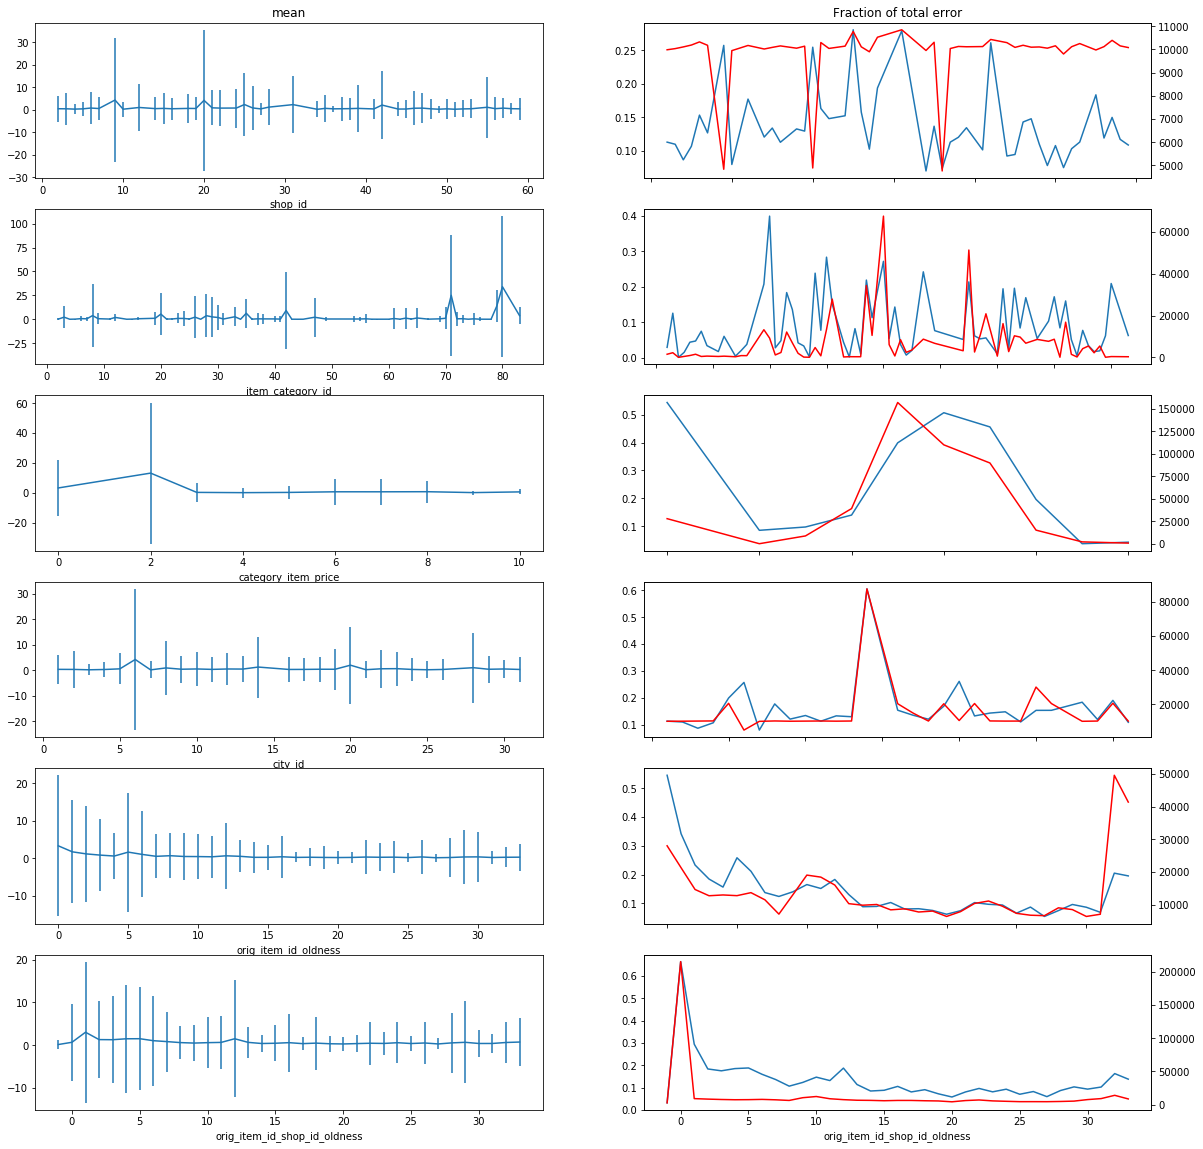

In [19]:
error_col = 'sqr_error'
evaluation_cols = ['shop_id','item_category_id','category_item_price','city_id','orig_item_id_oldness','orig_item_id_shop_id_oldness']
df = val_X[evaluation_cols].copy()
df['prediction'] =model.predict(pool_val)
df['actual'] = val_y

df['error'] = df['prediction'] - df['actual']
df['abs_error'] =df['error'].abs()
df['sqr_error'] = df['error'].pow(2)

_, ax = plt.subplots(nrows=len(evaluation_cols), ncols=2,figsize=(20,20))
for i,col in enumerate(evaluation_cols):
    grp = df.groupby(col)[error_col]    
    grp.mean().plot(yerr=grp.std(),title='mean' if i ==0 else None, ax=ax[i,0])     
    
    twinx = ax[i,1].twinx()
    (grp.sum()/grp.sum().sum()).apply(np.sqrt).plot(ax=ax[i,1],title='Fraction of total error' if i ==0 else None,)
    grp.count().plot(ax=twinx,c='r')
    if col == 'orig_item_id_oldness':
        print('Net Square error\n',grp.sum())


**About 50% of the error is just coming from new item ids.(2nd last row)**

In [20]:
if not FINAL_MODEL_FOR_TEST:
    del pool_train, pool_val, train_X, train_y, val_X, val_y
else:    
    del  X, y,pool_train

In [21]:
gc.collect()

183

## Feature Importances

Text(0.5, 0, 'importance')

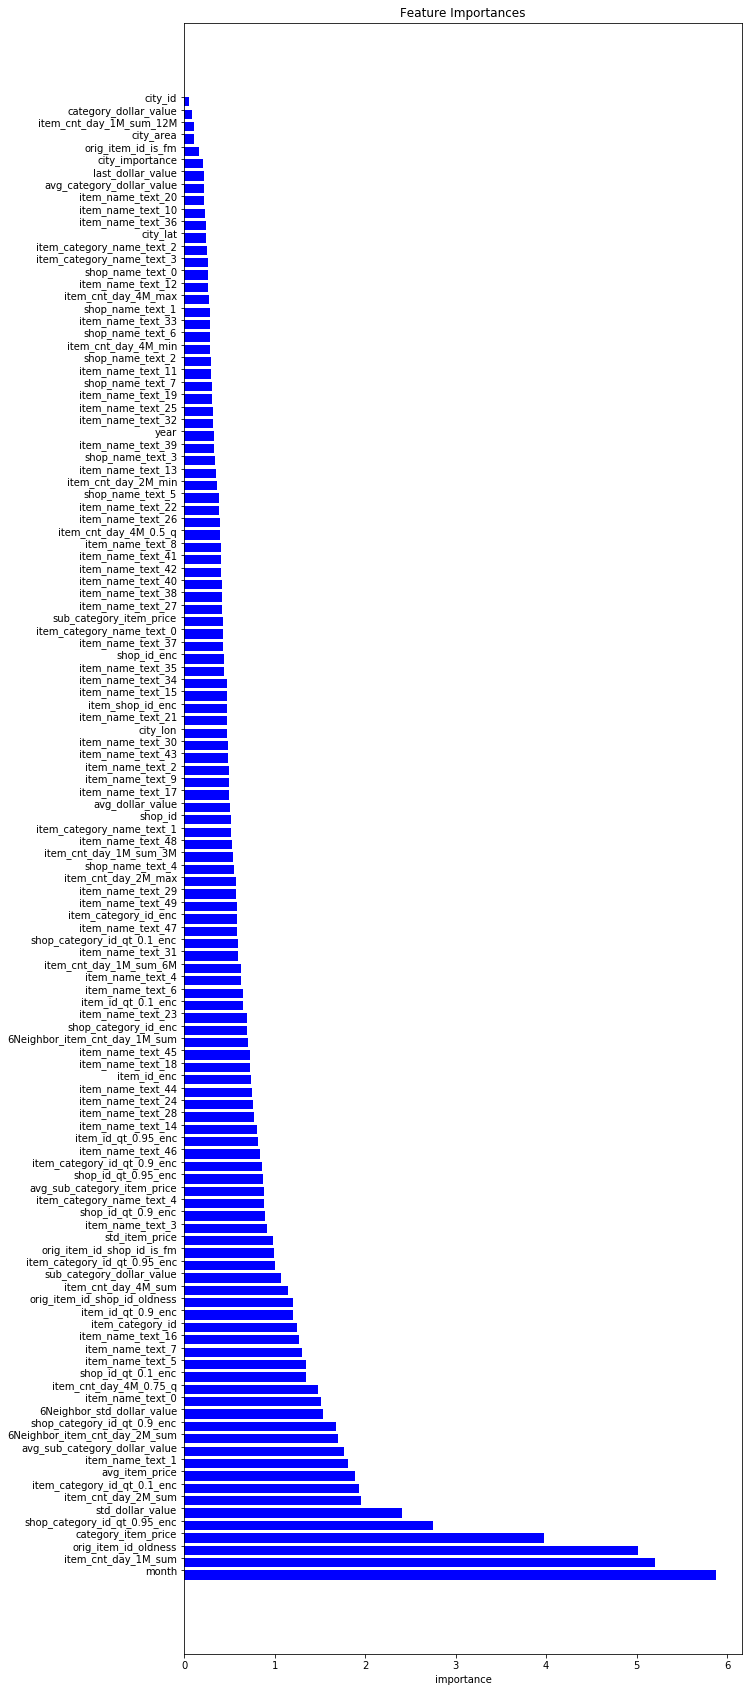

In [22]:
import matplotlib.pyplot as plt
importances = model.get_feature_importance(prettified=True)
x = np.array(list(range(len(importances))))
y = [imp for (_,imp) in importances]
my_xticks = [col for (col,_) in importances]
fig, ax = plt.subplots(figsize=(10,30))    
width = 0.75 # the width of the bars 
ax.barh(x, y, width, color="blue")
ax.set_yticks(x+width/2)
ax.set_yticklabels(my_xticks, minor=False)
plt.title('Feature Importances')
plt.xlabel('importance')

In [23]:
model.save_model(TRAINED_MODEL_FPATH)

## Data Leakage

In [24]:
# import pandas as pd


# def get_unexpected_category_entries_filter(val_df, sales_df, items_df):
#     min_dbn = val_df.date_block_num.min()
#     sales_df = sales_df[sales_df.date_block_num < min_dbn]
#     sales_df = sales_df[sales_df.item_cnt_day != 0]
#     if 'item_category_id' not in sales_df:
#         sales_df = pd.merge(sales_df, items_df[['item_id', 'item_category_id']], how='left', on='item_id')

#     assert 'item_category_id' in val_df

#     sales_df['shop_category_id'] = sales_df['shop_id'] * 100 + sales_df['item_category_id']

#     assert 'shop_category_id' not in val_df
#     val_df['shop_category_id'] = val_df['shop_id'] * 100 + val_df['item_category_id']

#     new_item_list = set(val_df.item_id.values) - set(sales_df.item_id.values)
#     new_shop_list = set(val_df.shop_id.values) - set(sales_df.shop_id.values)
    
#     print('New items count', len(new_item_list))
#     print('New shops count', len(new_shop_list))
    
#     old_items_filter = ~val_df.item_id.isin(new_item_list)
#     old_shops_filter = ~val_df.shop_id.isin(new_shop_list)
#     old_item_shops_filter = old_items_filter & old_shops_filter

#     new_shop_category_id_list = set(val_df.shop_category_id.values) - set(sales_df.shop_category_id.values)

#     zero_filter = val_df.shop_category_id.isin(new_shop_category_id_list) & old_item_shops_filter

#     val_df.drop('shop_category_id', inplace=True, axis=1)
#     return zero_filter


## Prediction on Test

In [25]:
X_test=pd.read_hdf(COMBINED_DATA_FPATH,'X_test')
sample_submissions_df = pd.read_csv(SAMPLE_SUBMISSION_FPATH, index_col=0)

X_test = X_test.loc[sample_submissions_df.index,:]
test_prediction = model.predict(Pool(data=X_test[X_cols]))

test_prediction[test_prediction > 20] = 20
test_prediction[test_prediction < 0]  = 0
sample_submissions_df['item_cnt_month'] = test_prediction


# # Data leakage.
# orig_sales_df = pd.read_csv(ORIG_SALES_FPATH)
# orig_items_df = pd.read_csv(ORIG_ITEMS_FPATH)
# sample_submissions_df['date_block_num'] = 34

# X_test[['item_id','shop_id','item_category_id']] = X_test[['item_id','shop_id','item_category_id']].astype(np.uint32)
# f = get_unexpected_category_entries_filter(X_test, orig_sales_df, orig_items_df)
# print('Setting {} fraction of entries to zero sales as they comprise of out of category old item shop pairs'.format(f.sum()/sample_submissions_df.shape[0]))
# print(sample_submissions_df[f]['item_cnt_month'].describe())
# sample_submissions_df.loc[f,'item_cnt_month'] = 0
# sample_submissions_df.drop('date_block_num',axis=1,inplace=True)



sample_submissions_df.to_csv('submission.csv')

